In [2]:
import sys 
sys.path.append('/ai-data/chest/kjs2109/baseline/detectron2-baseline') 
from inference.inference_model import InferenceModel 

/home/kjs2109/.conda/envs/deepai-kjs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch 

SEG_CONFIG_DICT = {
    'weight_path' : '/ai-data/chest/kjs2109/baseline/detectron2-baseline/weight_dir/COCO-InstanceSegmentation/COCO-InstanceSegmentation_BORA_EVAL_1Findings_1gpus_512bs_8workers_MRCNN_1024_0.0001LR_WCLR_mask_rcnn_R_101_FPN_3x/model_best_0.0000.pth',
    'model_zoo_config': 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml',
    'input_min_size_test': 1024,
    'input_max_size_test': 1024,
    'model_roi_heads_batch': 512,
    'model_roi_heads_threshold': 0.5,
    'CLASSES': ['Pneumothorax'],
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
} 

model = InferenceModel(SEG_CONFIG_DICT) 
model

In [4]:
import os 
import cv2 

image_dir = '/ai-data/chest/kjs2109/private_data/chestALL/images' 
image1_fname = 'BORA_CXR_002768.jpg' 
image2_fname = 'BORA_CXR_000132.jpg'

img1 = cv2.imread(os.path.join(image_dir, image1_fname)) 
img2 = cv2.imread(os.path.join(image_dir, image2_fname)) 

In [5]:
print('shape:', img1.shape)
print('type:', type(img1)) 
print('min:', img1.min()) 
print('max:', img1.max()) 
print(type(img1[0][0]))
print(type(img1[0][0][0]))  

shape: (3001, 2568, 3)
type: <class 'numpy.ndarray'>
min: 0
max: 255
<class 'numpy.ndarray'>
<class 'numpy.uint8'>


In [ ]:
scores, cat_ids, boxes, maskes = model.inference(img1)

/home/kjs2109/.conda/envs/deepai-kjs/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
scores

array([0.98768437, 0.56355846], dtype=float32)

In [ ]:
cat_ids

array([0, 0])

In [ ]:
boxes

array([[1402.2609 ,  336.93918, 2474.3044 , 2671.104  ],
       [1423.1929 ,  332.45947, 2345.7825 , 1550.1338 ]], dtype=float32)

In [ ]:
maskes.shape

(2, 3001, 2568)

In [ ]:
import numpy as np 

mask_imsi = maskes[0] 
mask_index = np.where(mask_imsi > 0) 
print(np.array(mask_index)) 

[[ 349  349  349 ... 2517 2517 2518]
 [1704 1705 1706 ... 2301 2302 2301]]


In [ ]:
mask_imsi[mask_index]  # [x, y]

array([ True,  True,  True, ...,  True,  True,  True])

(3001, 2568, 3)
<class 'numpy.ndarray'>
0
255


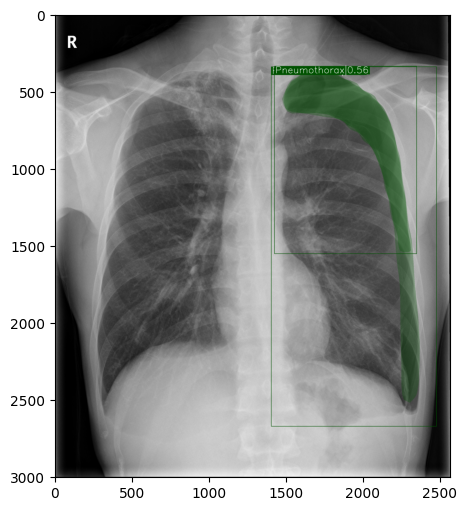

In [ ]:
import matplotlib.pyplot as plt 

img = model.get_pred_show(img1, mode=['mask', 'box'], threshold=0.2)
print(img.shape) 
print(type(img))
print(img.min()) 
print(img.max()) 
plt.figure(figsize=(6, 6))
plt.imshow(img) 
plt.show() 

In [ ]:
from inference.inference_model import plot_inference_result 

In [ ]:
import pandas as pd 

total_image_df = pd.read_csv('/ai-data/chest/kjs2109/private_data/total_image_df_v1.csv') 
len(total_image_df) 

64852

In [ ]:
over_5_disease_df = pd.read_csv('/ai-data/chest/kjs2109/private_data/over_5_disease_df.csv')
len(over_5_disease_df) 

487

In [ ]:
over_5_disease_df.head() 

image_fname            xml_fname  consolidation  pneumothorax  \
0  BORA_CXR_009326.jpg  BORA_CXR_009326.xml              3             0   
1  PAIK_CXR_004202.jpg  PAIK_CXR_004202.xml              2             0   
2  PAIK_CXR_004169.jpg  PAIK_CXR_004169.xml              2             0   
3  BORA_CXR_000811.jpg  BORA_CXR_000811.xml              4             0   
4    CB_CXR_006671.jpg    CB_CXR_006671.xml              0             0   

   fibrosis  effusion  nodule  normal  num_disease  
0         0         2       0       0            5  
1         2         1       0       0            5  
2         0         2       1       0            5  
3         0         1       0       0            5  
4         2         0       3       0            5

In [ ]:
model.PALETTE

[(220, 20, 60), (0, 82, 0), (0, 0, 142), (220, 220, 0), (106, 0, 228)]

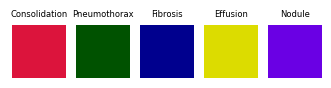

In [ ]:
# 병변별 annotation 색 시각화 
target_classes = ['Consolidation', 'Pneumothorax', 'Fibrosis', 'Effusion', 'Nodule'] 

plt.figure(figsize=(4, 20)) 
for i, color in enumerate(model.PALETTE): 
    plt.subplot(1, 5, i+1)
    plt.imshow(np.ones((10, 10, 3), dtype=np.uint8) * color)
    plt.title(target_classes[i], fontsize=6)
    plt.axis('off') 

100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


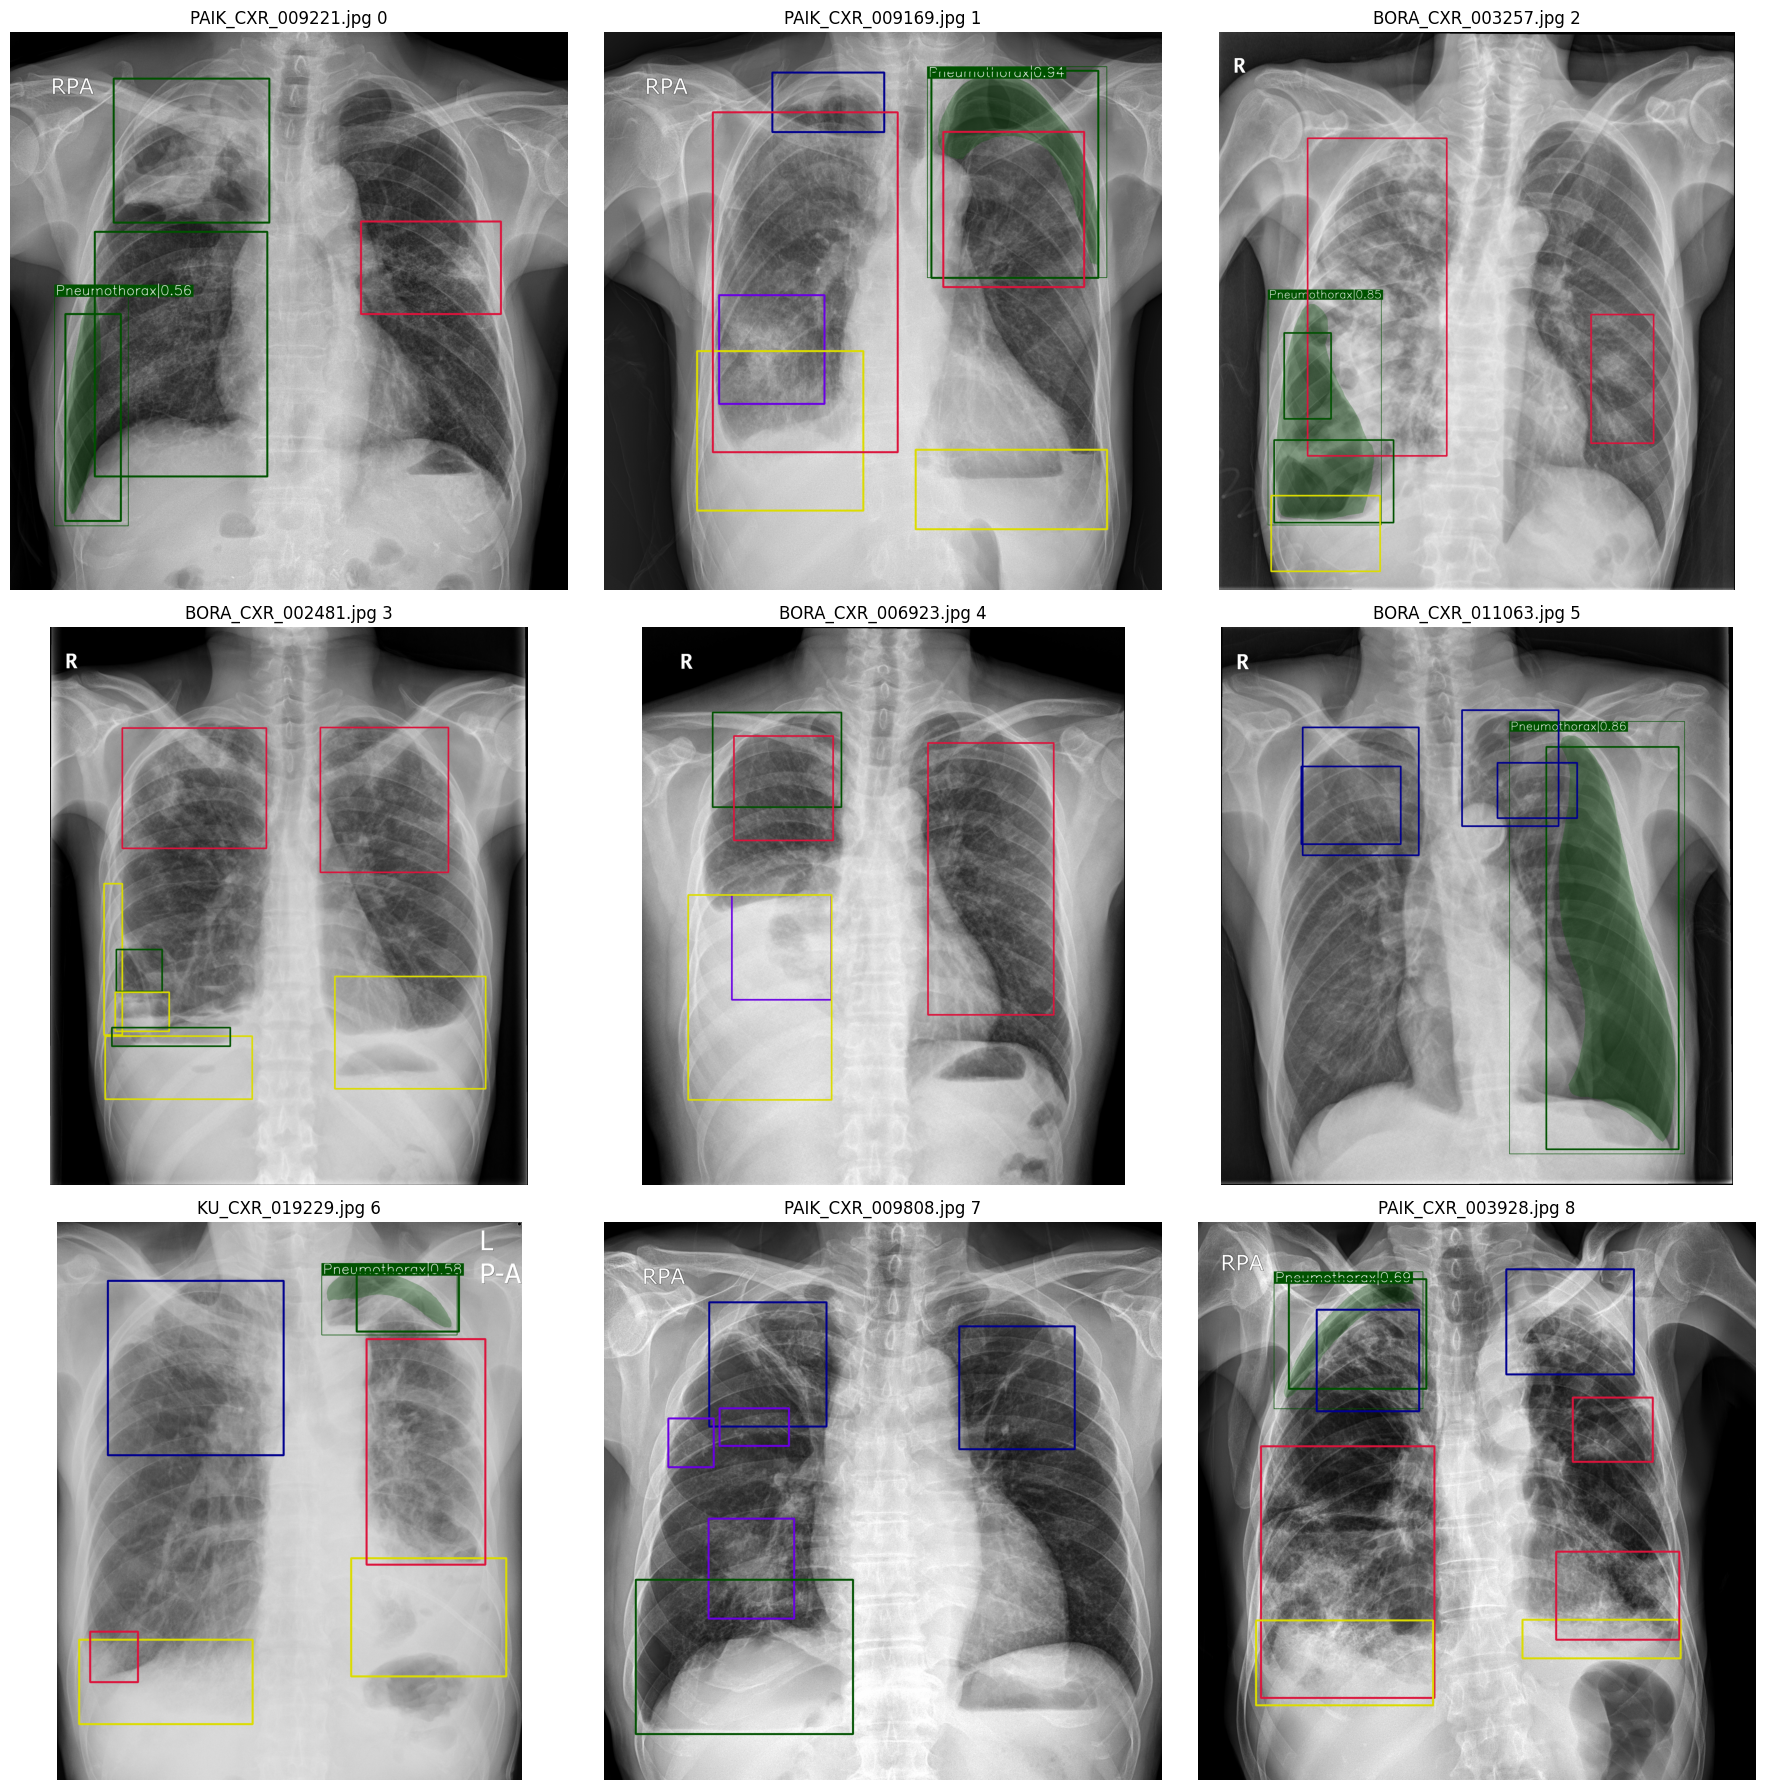

In [ ]:
import random 
import pandas as pd 

 
pneumothorax_df = over_5_disease_df[over_5_disease_df['pneumothorax'] >= 1] 

random.seed(42)               
image_fnames = random.sample(list(pneumothorax_df['image_fname']), 9) 

plot_inference_result(model, image_fnames, gt=True, mode=['mask', 'box'], threshold=0.5) 

100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


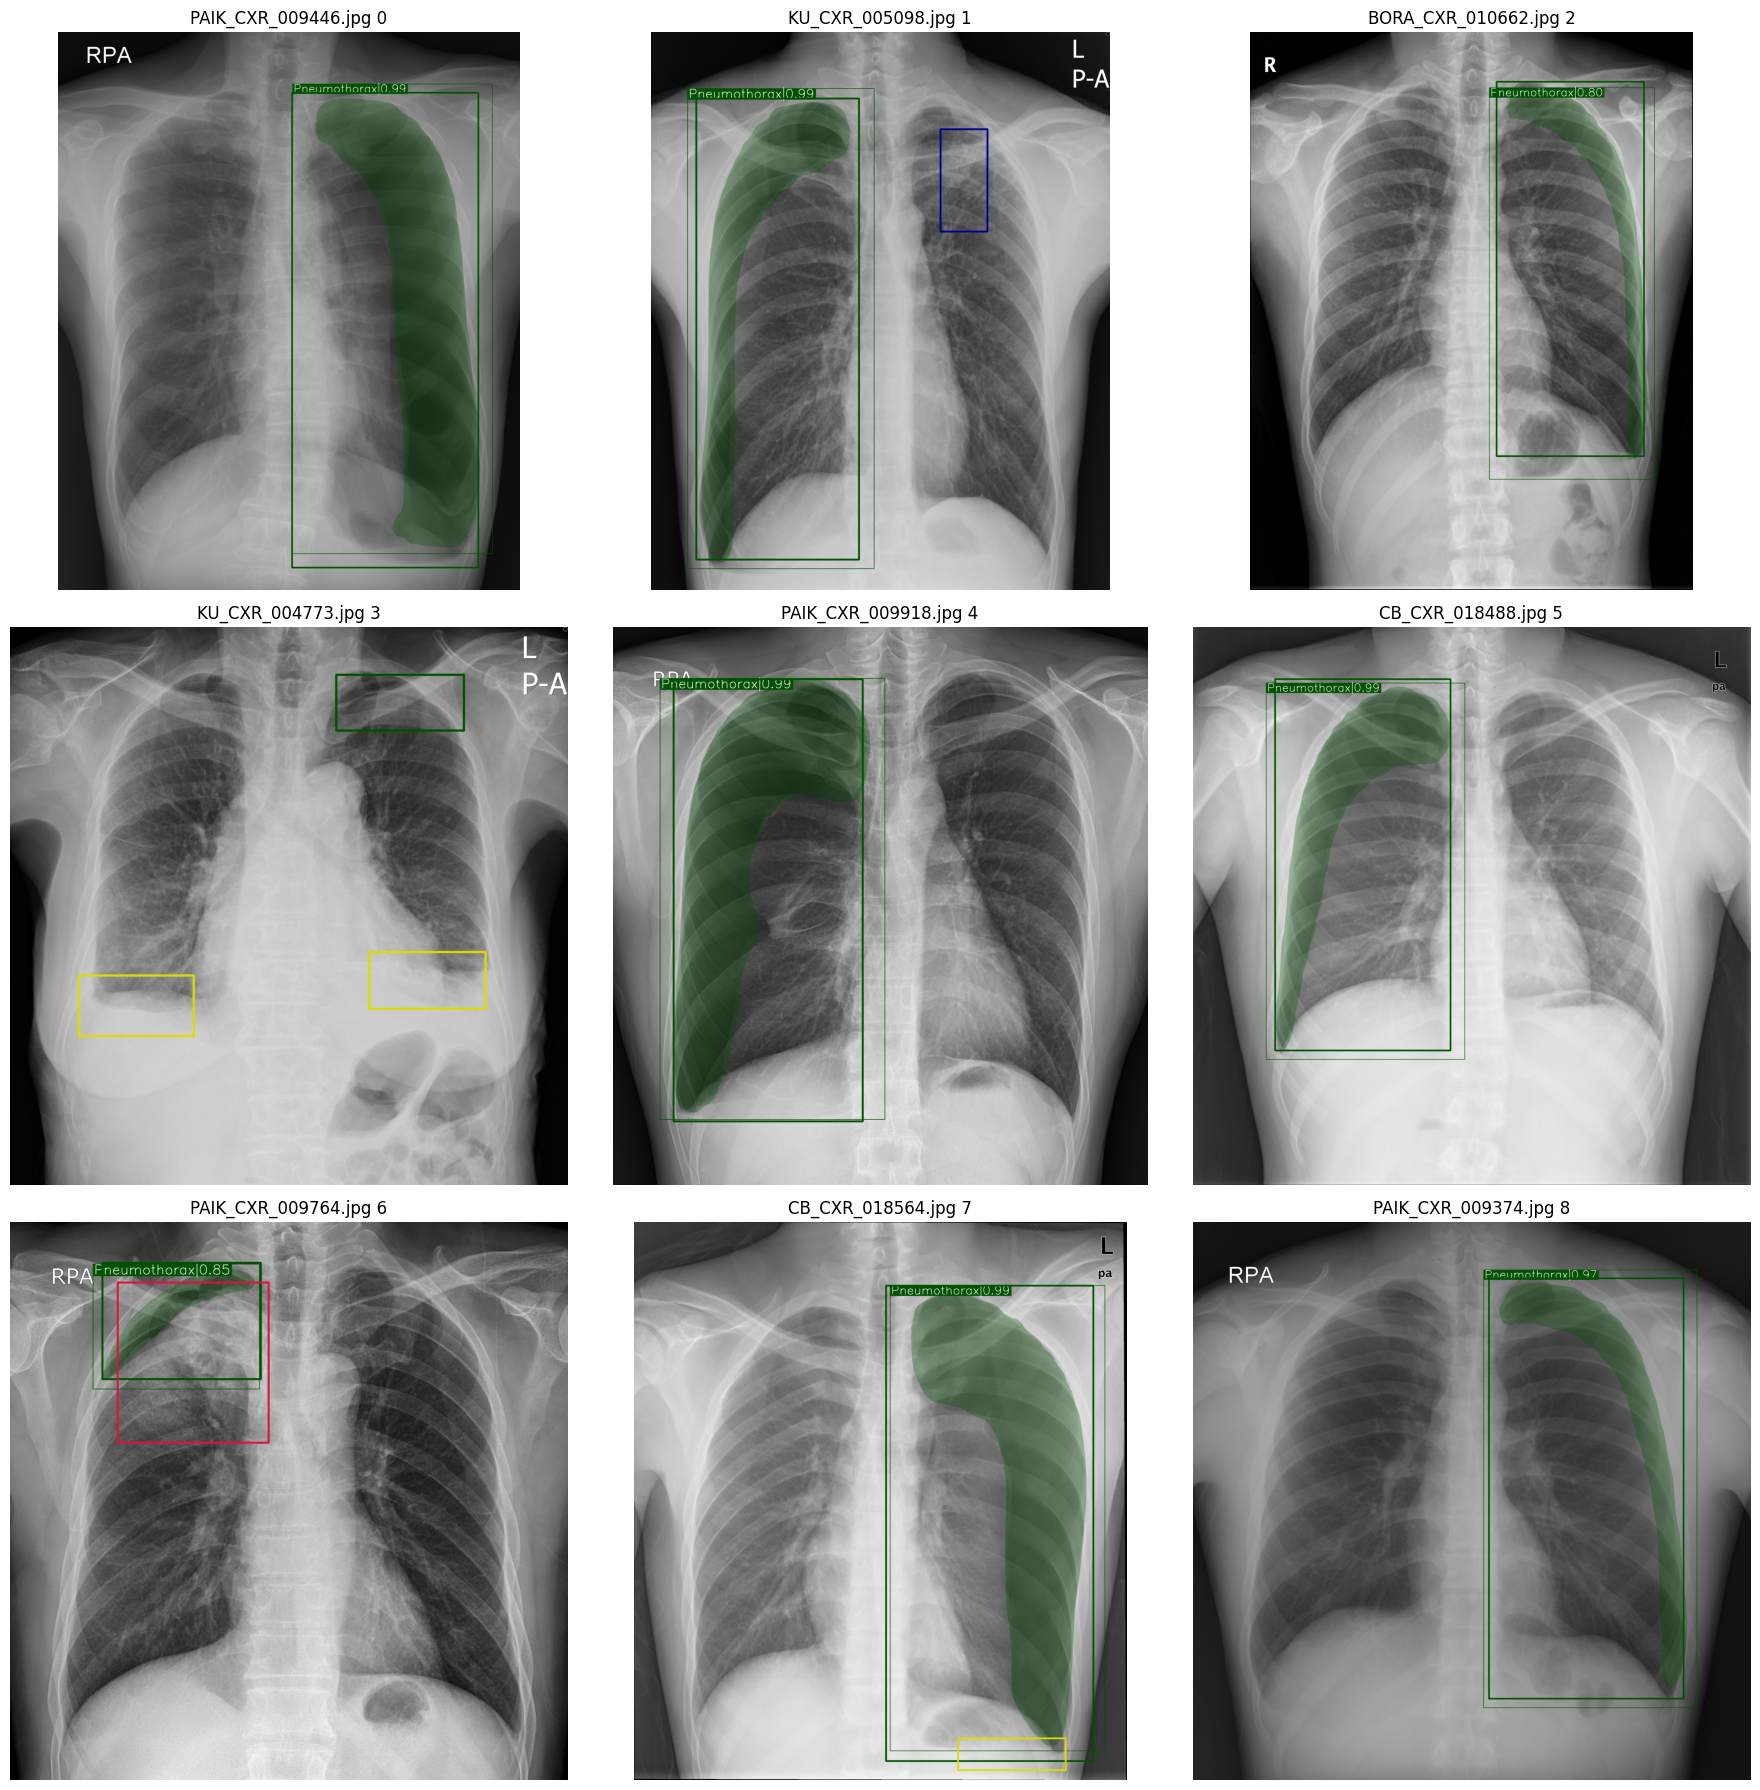

In [ ]:
random.seed(42)               
total_pneumothorax_df = total_image_df[total_image_df['pneumothorax'] >= 1]  
image_fnames = random.sample(list(total_pneumothorax_df['image_fname']), 9) 

plot_inference_result(model, image_fnames, gt=True, mode=['mask', 'box'], threshold=0.5) 
